In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [5]:
# Set up files
mydir = 'data/ordinaryFiveBlocksData'
files = [f for f in os.listdir(mydir) if f.endswith('.csv')]

numSubj = len(files)
print('Number of subjects: ', numSubj)

Number of subjects:  12


In [6]:
# Initialize variables
numRepeats = 10 # 10 passages
block_start = 2
block_end = block_start + numRepeats - 1   # the last block
numQPerPsg = 5

subj_include = [None] * numSubj
subj_readingSpeed = [None] * numSubj
subj_thresholds = np.full((numSubj, numRepeats), np.nan)

print('Shape thresholds matrix:', subj_thresholds.shape)

Shape thresholds matrix: (12, 10)


In [7]:
for subj in range(numSubj):
    mainOutput = pd.read_csv(os.path.join(mydir, files[subj]))

    psg_resp = np.full((numRepeats, numQPerPsg), np.nan)

    # Check if the participant got at least 50% accuracy
    for psg in range(2, 12):
        questionBlock = psg * 2

        labelName_question = f"{questionBlock}_1"
        questionBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_question].iloc[:numQPerPsg]

        psg_resp[psg - 2, :] = (
            questionBlock_cond['questionAndAnswerCorrectAnswer'] ==
            questionBlock_cond['questionAndAnswerResponse']
        ).values

    psg_percentCorrect = np.nanmean(psg_resp, axis=1)
    assert psg_percentCorrect.shape == (numRepeats,)

    # Whether we should include this passage
    psg_include = np.where(psg_percentCorrect >= 0.6)[0]


    # Calculate reading speed
    psg_wordsPerMin = np.full(numRepeats, np.nan)
    for psg in range(2, 12):
        readingBlock = psg * 2 - 1

        labelName_reading = f"{readingBlock}_1"
        readingBlock_cond = mainOutput[mainOutput['block_condition'] == labelName_reading].iloc[1:3]
        numWords = readingBlock_cond['readingPageWords']
        reading_time = readingBlock_cond['readingPageDurationOnsetToOffsetSec']
        pg_wordsPerMin = numWords / (reading_time / 60)
        psg_wordsPerMin[psg - 2] = np.nanmean(pg_wordsPerMin)

    subj_include[subj] = psg_include
    psg_wordsPerMin[np.where(psg_percentCorrect < 0.6)] = np.nan
    subj_readingSpeed[subj] = psg_wordsPerMin[psg_include]
    subj_thresholds[subj, psg_include] = psg_wordsPerMin[psg_include]


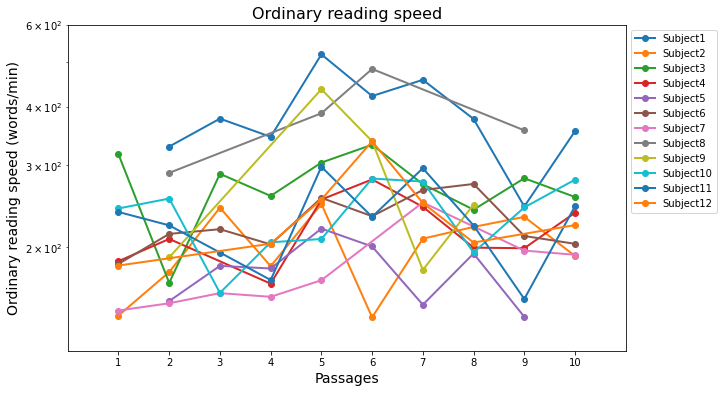

In [8]:
# Plot reading speed
# passage 0 was excluded as practice
cmap = plt.cm.jet(np.linspace(0, 0.8, numSubj))

plt.figure(figsize = (10, 6))
for subj in range(numSubj):
    plt.plot(subj_include[subj]+1, subj_readingSpeed[subj], 'o-', linewidth=2, #color=cmap[subj],
        label=f'Subject{subj + 1}'
    )
plt.xlim([0, 11])
plt.xticks(range(1, 11))
plt.ylim([120, 600])
plt.title('Ordinary reading speed', fontsize = 16)
plt.xlabel('Passages', fontsize = 14)
plt.ylabel('Ordinary reading speed (words/min)', fontsize = 14)
plt.yscale('log')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [11]:
subj_readingSpeed

[array([328.75552716, 377.33118523, 344.91608138, 518.1117285 ,
        421.81612248, 456.96246416, 376.70443353, 244.63239452,
        354.74542102]),
 array([142.78363305, 177.00515144, 243.15929248, 182.16817271,
        247.7057354 , 141.57646807, 208.66331184, 221.11895636,
        232.37642421, 191.61652259]),
 array([316.3488762 , 167.80200496, 287.38047116, 257.65986282,
        303.7604383 , 331.70777074, 273.07515435, 240.74009303,
        281.14823502, 256.29776615]),
 array([186.74748233, 208.40333848, 167.15782525, 253.12648359,
        279.5316192 , 244.19656026, 199.64661622, 199.06449828,
        237.17080631]),
 array([153.35224354, 182.4782855 , 180.12438037, 219.30910059,
        200.78706687, 150.63948948, 193.91840627, 141.88528641]),
 array([184.26995512, 213.65072189, 218.67607809, 202.86229869,
        255.27052049, 233.12992117, 265.30920247, 273.34253981,
        211.47719181, 203.42214105]),
 array([146.40054607, 151.71540865, 159.5019063 , 156.62798001,
    

In [14]:
df_reading = pd.DataFrame(subj_readingSpeed)
df_reading

,0,1,2,3,4,5,6,7,8,9
0,328.755527,377.331185,344.916081,518.111729,421.816122,456.962464,376.704434,244.632395,354.745421,NaN
1,142.783633,177.005151,243.159292,182.168173,247.705735,141.576468,208.663312,221.118956,232.376424,191.616523
2,316.348876,167.802005,287.380471,257.659863,303.760438,331.707771,273.075154,240.740093,281.148235,256.297766
3,186.747482,208.403338,167.157825,253.126484,279.531619,244.196560,199.646616,199.064498,237.170806,NaN
4,153.352244,182.478285,180.124380,219.309101,200.787067,150.639489,193.918406,141.885286,NaN,NaN
5,184.269955,213.650722,218.676078,202.862299,255.270520,233.129921,265.309202,273.342540,211.477192,203.422141
6,146.400546,151.715409,159.501906,156.627980,169.999835,249.531275,196.758295,192.731033,NaN,NaN
7,288.739675,387.448109,482.154383,356.129415,NaN,NaN,NaN,NaN,NaN,NaN
8,190.282960,436.170244,337.476227,178.862979,246.841637,NaN,NaN,NaN,NaN,NaN
9,242.241133,254.345838,159.714291,204.993976,208.315391,280.753344,276.608245,194.952838,243.467024,279.202134


In [15]:
df_reading.to_csv('df_reading.csv', index=False)